We will use a artificial recurrent nueral network called a LSTM (Long Short Term Memory) to predict Housing prices. I will pull data from the sql databases that I created *test changes*


In [8]:
#import Libraries
import math 
import pandas_datareader as web
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.style.use('fivethirtyeight')
import datetime
import pandas as pd
import sqlalchemy as sa


In [9]:
#need to create a connection string between the server and python
connection_string_Housing = "mssql+pyodbc:///?odbc_connect=DRIVER={ODBC Driver 18 for SQL Server};SERVER=KALLESPC;DATABASE=Housing;Encrypt=NO;Trusted_Connection=yes"
connection_string_GDP_GROWTH = "mssql+pyodbc:///?odbc_connect=DRIVER={ODBC Driver 18 for SQL Server};SERVER=KALLESPC;DATABASE=GDP_GROWTH_1998_2024_STATE;Encrypt=NO;Trusted_Connection=yes"
engine = sa.create_engine(connection_string_Housing)

#upload,read and show table
Housing_prices_df = pd.read_sql('hpi_po_monthly_hist', engine)
print (Housing_prices_df.head())





     column1     column2     column3     column4     column5     column6  \
0 1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1 1991-02-01  100.870003  100.860001  100.889999  100.500000  100.040001   
2 1991-03-01  101.320000  100.900002  100.800003  100.410004  100.059998   
3 1991-04-01  101.720001  100.970001  100.739998  100.459999   99.599998   
4 1991-05-01  102.320000  101.300003  101.040001  100.629997   99.720001   

      column7     column8     column9    column10  ...    column12  \
0  100.000000  100.000000  100.000000  100.000000  ...  100.000000   
1  100.089996   98.370003   98.790001  101.650002  ...  100.180000   
2   99.750000  100.349998  100.699997  101.430000  ...   99.959999   
3   99.250000  100.269997  100.330002  100.930000  ...  100.139999   
4   99.199997  100.739998  100.550003   99.739998  ...  100.339996   

     column13    column14    column15    column16    column17    column18  \
0  100.000000  100.000000  100.000000  100.00

In [10]:
#Get number of rows and columns
print(Housing_prices_df.shape)
print (Housing_prices_df['column2'].max())

(411, 21)
367.010009765625


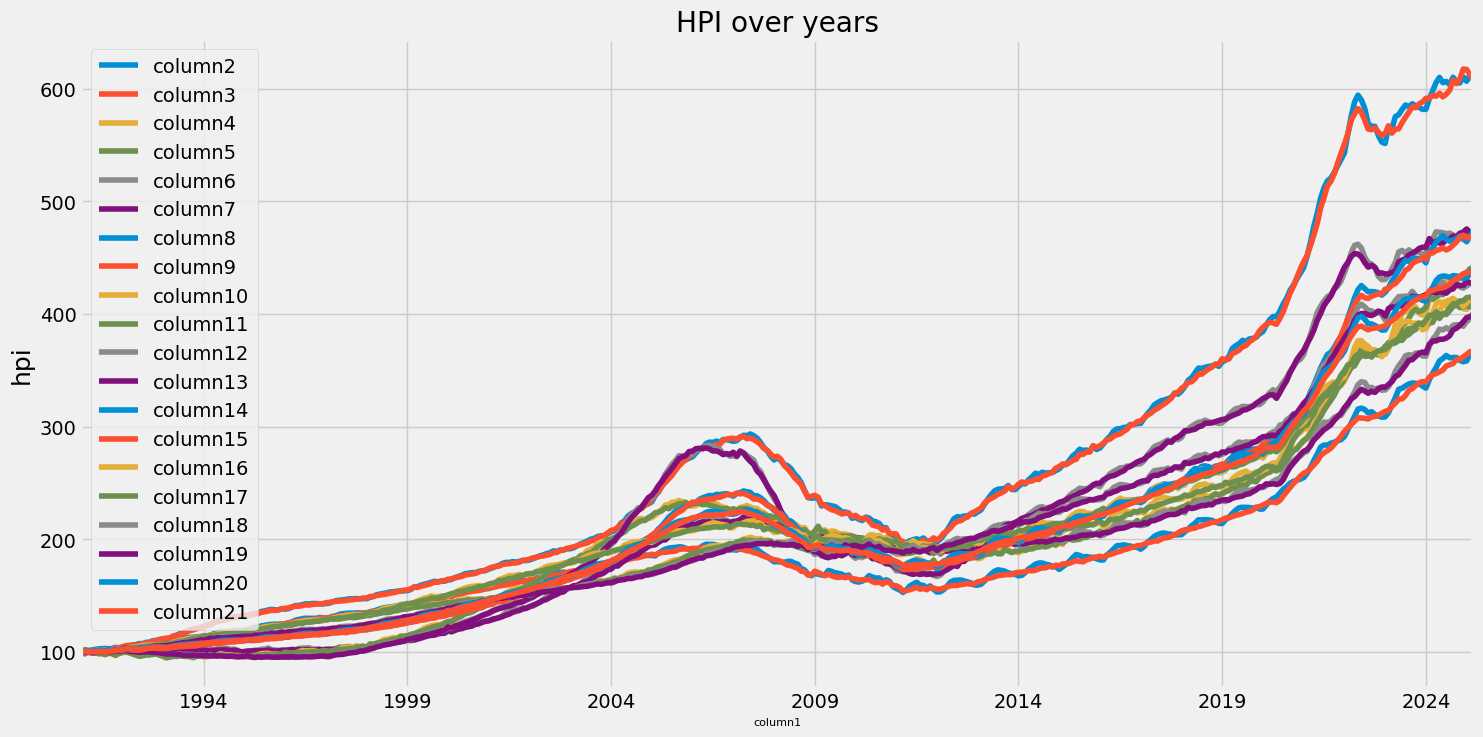

In [11]:
#Visualize the data 
#Housing_prices_df['Year'] = pd.to_datetime(Housing_prices_df['Year'])
Housing_prices_df.set_index('column1',inplace=True)
Housing_prices_df.sort_index(inplace=True)
plt.figure(figsize=(16,8))
plt.title('HPI over years')
#plt.plot(Housing_prices_df['Year'],Housing_prices_df['avg_hpi'])
plt.xlabel('Date', fontsize=8)
plt.ylabel('hpi', fontsize=18)
Housing_prices_df.plot(ax=plt.gca())
plt.show()

In [12]:
#create a new dataframe with only the "Close" column
close_stock = Housing_prices_df#.filter(['avg_hpi_year'])
#Convert the data frame to a numpy array
dataset = close_stock.to_numpy()
dataset.shape
#get the number of rows to train the model on 
Training_data_len = math.ceil(len(dataset)*.9)
Training_data_len


370

In [13]:
#Good practice to Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
#create variable to hold scaled data
print(dataset.shape)
scaled_data = scaler.fit_transform(dataset)#<----computes minimum and maximum values that are used for scaling and transforms data based on those values

scaled_data

(411, 20)


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.81890663e-04, 0.00000000e+00, 0.00000000e+00],
       [3.25831510e-03, 3.22423640e-03, 2.84909205e-03, ...,
        0.00000000e+00, 1.05957323e-03, 1.15795547e-03],
       [4.94363375e-03, 3.37420421e-03, 2.56099315e-03, ...,
        2.61525556e-03, 1.97197478e-03, 1.36579306e-03],
       ...,
       [9.67679096e-01, 9.90139824e-01, 9.73557815e-01, ...,
        1.00000000e+00, 9.77896134e-01, 9.99703160e-01],
       [9.90150164e-01, 1.00000000e+00, 9.83705755e-01, ...,
        9.98205825e-01, 9.89551394e-01, 1.00000000e+00],
       [1.00000000e+00, 9.94451277e-01, 1.00000000e+00, ...,
        9.94313359e-01, 1.00000000e+00, 9.99287440e-01]])

In [14]:
#Create the training data set
#Create the Scaled training data set
train_data = scaled_data[0:Training_data_len , :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(308, len(train_data)):
    x_train.append(train_data[i-308:i,0])
    y_train.append(train_data[i,0])
    if i<=309:
        print(x_train)
        print(y_train)
        print()
#the first 229 values(x_train) are the values that will train the data to predict the 230th value(y_train)

[array([0.        , 0.00325832, 0.00494363, 0.00644171, 0.00868881,
       0.01052394, 0.01127299, 0.0117224 , 0.01067375, 0.01153515,
       0.01490582, 0.01396953, 0.01441893, 0.01632898, 0.02071083,
       0.02217145, 0.02438112, 0.02606644, 0.02666568, 0.02820119,
       0.02820119, 0.03056067, 0.03149696, 0.03277031, 0.03138458,
       0.03123477, 0.03441819, 0.03816337, 0.04041047, 0.04467997,
       0.045429  , 0.04715178, 0.04887458, 0.0494738 , 0.05059736,
       0.05164601, 0.05254484, 0.05381822, 0.05651472, 0.0608966 ,
       0.06411746, 0.06681396, 0.06696377, 0.06842439, 0.06849931,
       0.07078387, 0.071458  , 0.07052171, 0.07123327, 0.07445413,
       0.07628929, 0.081158  , 0.08228156, 0.08685069, 0.08849854,
       0.09070821, 0.09168197, 0.09269315, 0.09216883, 0.0937418 ,
       0.09310513, 0.09681284, 0.099809  , 0.10557658, 0.10823562,
       0.11025805, 0.11254261, 0.11160631, 0.11231791, 0.11164375,
       0.11475225, 0.11415301, 0.11205572, 0.1144152 , 0.1187

In [15]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [16]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(62, 308, 1)

In [17]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences= True, input_shape= (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

d:\Python_programming_environment\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
#train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0410


In [20]:
#Create the testing data set
test_data = scaled_data[Training_data_len - 40: , :  ]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[Training_data_len:, :]
for i in range(40, len(test_data)):
    x_test.append(test_data[i-40:i, 0])
    

In [21]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [22]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1], 1 ))

In [23]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


ValueError: non-broadcastable output operand with shape (41,1) doesn't match the broadcast shape (41,20)

In [ ]:
#Get the root mean squared error (RMSE) it is the standard deviation of the residuals and you want lower values
rmse = np.sqrt(np.mean(predictions - y_test)**2 )
rmse

np.float64(8.9965105010242)

C:\Users\kalle\AppData\Local\Temp\ipykernel_12948\2337052924.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


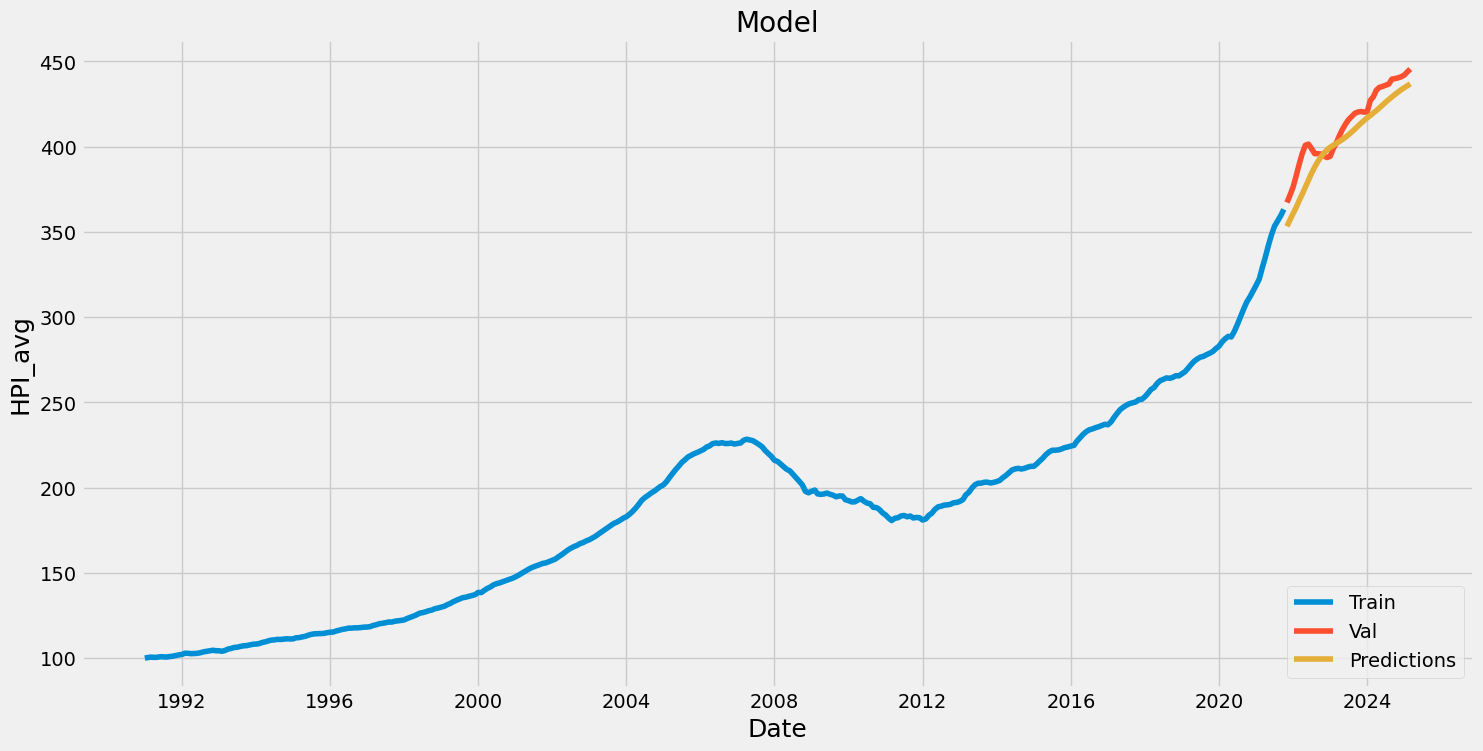

In [ ]:
#Plot the data
train = Housing_prices_df[:Training_data_len]
valid = Housing_prices_df[Training_data_len:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('HPI_avg', fontsize=18)
plt.plot(train['avg_hpi'])
plt.plot(valid[['avg_hpi','Predictions']])
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

In [ ]:
#Show the valid and predicted prices
valid

,avg_hpi,Predictions
column1,,
2021-11-01,367.210999,353.260834
2021-12-01,371.511502,357.036713
2022-01-01,376.375504,360.773804
2022-02-01,383.091502,364.494812
2022-03-01,389.563000,368.279053
2022-04-01,395.991502,372.168518
2022-05-01,400.785500,376.184723
2022-06-01,401.434000,380.280151
2022-07-01,398.893498,384.276886
